In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

matfile = scipy.io.loadmat("ballbeam.mat")
u = matfile["U"]
y = matfile["Y"]

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
%matplotlib inline

In [3]:

class LSTMSystem(nn.Module):
    # https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
    def __init__(self, input_dim, hidden_dim, fc_hidden_dim, output_dim):
        # input_dim = control_dim + exact_lag_dim(option)
        super(LSTMSystem, self).__init__()
        self.hidden_dim = hidden_dim

        #self.word_embeddings = nn.Embedding(vocab_size, input_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.fc1 = nn.Linear(hidden_dim, fc_hidden_dim)
        self.fc2 = nn.Linear(fc_hidden_dim, output_dim)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, inputs):
        lstm_out, self.hidden = self.lstm(
            inputs.view(len(inputs), 1, -1), self.hidden)
        out = F.relu(lstm_out)
        out = self.fc1(out.view(len(inputs), -1))
        out = F.relu(out)
        out = self.fc2(out)
        
        return out



In [4]:
def lag_design(x,lags):
    return np.transpose(np.array([np.roll(x,i) for i in range(lags+1)]))[lags:,:]
def design(y,u,lag_y,lag_u):
    Y = lag_design(y,lag_y)
    U = lag_design(u,lag_u)
    m = min(Y.shape[0],U.shape[0])
    return Y[:m,0],np.c_[Y[:m,1:],U[:m,:]]

def test_paramter(y_lag_size, u_lag_size, 
                  lr=0.01, num_iter = 100, cuda = False,
                  hidden_dim = 5, fc_hidden_dim = 5,
                  verbose = True):
    
    Y,U = design(y.reshape(-1), u.reshape(-1), y_lag_size, u_lag_size)
    
    inputs = torch.tensor(U, dtype=torch.float)
    targets = torch.tensor(Y.reshape((Y.shape[0],1)), dtype=torch.float)
    
    # define model
    input_dim = 1 + y_lag_size + u_lag_size
    
    output_dim = 1
    
    model = LSTMSystem(input_dim, hidden_dim, fc_hidden_dim, output_dim)
    
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    
    
    if cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()
        model.cuda()
    
    
    # See what the scores are before training
    # Note that element i,j of the output is the score for tag j for word i.
    # Here we don't need to train, so the code is wrapped in torch.no_grad()
    with torch.no_grad():
        #inputs = torch.tensor([[1.],[2.],[3.],[4.]])
        
        output = model(inputs[:3])
        if True:
            print(inputs[:3])
            print(output)
        
    #%time
    
    for epoch in range(num_iter):  # again, normally you would NOT do 300 epochs, it is toy data
        #for inputs, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
    
            # Also, we need to clear out the hidden state of the LSTM,
            # detaching it from its history on the last instance.
            model.hidden = model.init_hidden()
    
            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            #sentence_in = prepare_sequence(sentence, word_to_ix)
            #targets = prepare_sequence(tags, tag_to_ix)
            
    
            # Step 3. Run our forward pass.
            output = model(inputs)
    
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(output, targets)
            if verbose:
                print(f"{epoch}/{num_iter} loss: {loss.item()}")
            
            loss.backward()
            optimizer.step()
    
    with torch.no_grad():
        #inputs = torch.tensor([[1.],[2.],[3.],[4.]])
        output = model(inputs)
        loss = loss_function(output, targets)
        #print(output)
    
    plt.plot(u,label='u')
    plt.plot(y,label='y')
    plt.plot(output.numpy(),label='out')
    plt.legend()
    plt.show()
    
    return loss.item(),model

def steady_test(size, *args, **kwargs):
    loss_list = []
    model_list = []
    for i in range(size):
        loss, model = test_paramter(*args, **kwargs)
        loss_list.append(loss)
        model_list.append(model)
    return loss_list, model_list

tensor([[0.3211],
        [0.3202],
        [0.3197],
        [0.3192],
        [0.3189]])
0/100 loss: 0.11910299211740494
1/100 loss: 0.09959632903337479
2/100 loss: 0.0818914920091629
3/100 loss: 0.06591472029685974
4/100 loss: 0.0516444593667984
5/100 loss: 0.03911273181438446
6/100 loss: 0.02837749943137169
7/100 loss: 0.019564637914299965
8/100 loss: 0.012968248687684536
9/100 loss: 0.00819189753383398
10/100 loss: 0.005126018542796373
11/100 loss: 0.003727477276697755
12/100 loss: 0.0038306342903524637
13/100 loss: 0.005097542889416218
14/100 loss: 0.007018440403044224
15/100 loss: 0.009012715891003609
16/100 loss: 0.010598532855510712
17/100 loss: 0.011501056142151356
18/100 loss: 0.011654721572995186
19/100 loss: 0.011147742159664631
20/100 loss: 0.010154801420867443
21/100 loss: 0.00887972116470337
22/100 loss: 0.007517535239458084
23/100 loss: 0.0062315273098647594
24/100 loss: 0.005121749825775623
25/100 loss: 0.004246980417519808
26/100 loss: 0.003627122612670064
27/100 los

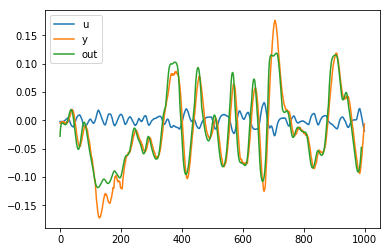

In [4]:
y_lag_size = 10
u_lag_size = 10



Y,U = design(y.reshape(-1), u.reshape(-1), y_lag_size, u_lag_size)

inputs = torch.tensor(U, dtype=torch.float)
targets = torch.tensor(Y.reshape((Y.shape[0],1)), dtype=torch.float)

# define model
input_dim = 1 + y_lag_size + u_lag_size
hidden_dim = 5
output_dim = 1
fc_hidden_dim = 5
model = LSTMSystem(input_dim, hidden_dim, fc_hidden_dim, output_dim)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


cuda = False
if cuda:
    inputs = inputs.cuda()
    targets = targets.cuda()
    model.cuda()


# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    #inputs = torch.tensor([[1.],[2.],[3.],[4.]])
    output = model(inputs[:5])
    print(output)


    
#%time
num_iter = 100
for epoch in range(num_iter):  # again, normally you would NOT do 300 epochs, it is toy data
    #for inputs, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        #sentence_in = prepare_sequence(sentence, word_to_ix)
        #targets = prepare_sequence(tags, tag_to_ix)
        

        # Step 3. Run our forward pass.
        output = model(inputs)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(output, targets)
        print(f"{epoch}/{num_iter} loss: {loss.item()}")
        
        loss.backward()
        optimizer.step()

with torch.no_grad():
    #inputs = torch.tensor([[1.],[2.],[3.],[4.]])
    output = model(inputs)
    #print(output)

plt.plot(u,label='u')
plt.plot(y,label='y')
plt.plot(output.numpy(),label='out')
plt.legend()
plt.show()

    

tensor([[-0.0049, -0.0020, -0.0020],
        [-0.0046, -0.0020, -0.0020],
        [-0.0038, -0.0020, -0.0020]])
tensor([[-0.0690],
        [-0.0694],
        [-0.0695]])


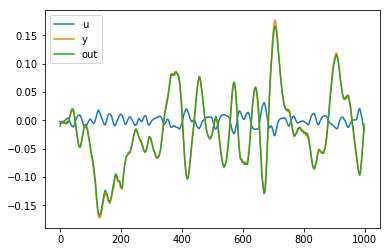

tensor([[-0.0049, -0.0020, -0.0020],
        [-0.0046, -0.0020, -0.0020],
        [-0.0038, -0.0020, -0.0020]])
tensor([[0.2701],
        [0.2673],
        [0.2658]])


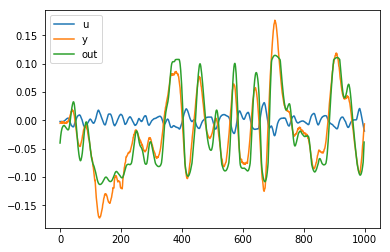

tensor([[-0.0049, -0.0020, -0.0020],
        [-0.0046, -0.0020, -0.0020],
        [-0.0038, -0.0020, -0.0020]])
tensor([[-0.1891],
        [-0.1815],
        [-0.1770]])


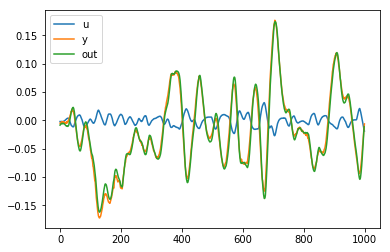

tensor([[-0.0049, -0.0020, -0.0020],
        [-0.0046, -0.0020, -0.0020],
        [-0.0038, -0.0020, -0.0020]])
tensor([[-0.2426],
        [-0.2307],
        [-0.2270]])


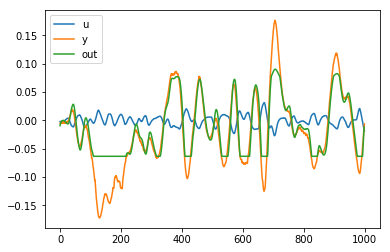

tensor([[-0.0049, -0.0020, -0.0020],
        [-0.0046, -0.0020, -0.0020],
        [-0.0038, -0.0020, -0.0020]])
tensor([[-0.4075],
        [-0.4005],
        [-0.3979]])


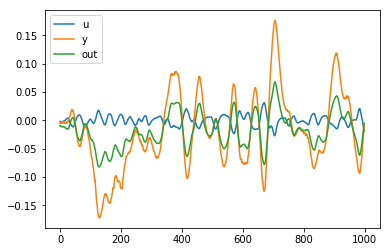

tensor([[-0.0049, -0.0020, -0.0020],
        [-0.0046, -0.0020, -0.0020],
        [-0.0038, -0.0020, -0.0020]])
tensor([[0.2927],
        [0.2884],
        [0.2878]])


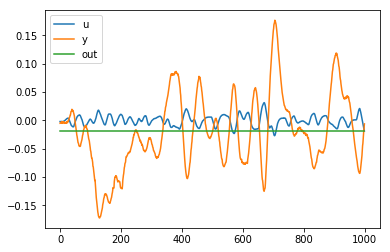

tensor([[-0.0049, -0.0020, -0.0020],
        [-0.0046, -0.0020, -0.0020],
        [-0.0038, -0.0020, -0.0020]])
tensor([[-0.4443],
        [-0.4304],
        [-0.4263]])


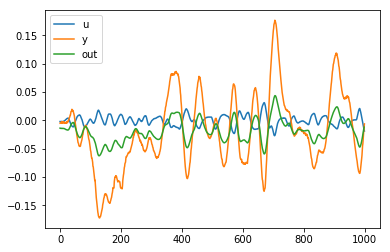

tensor([[-0.0049, -0.0020, -0.0020],
        [-0.0046, -0.0020, -0.0020],
        [-0.0038, -0.0020, -0.0020]])
tensor([[0.2923],
        [0.2929],
        [0.2940]])


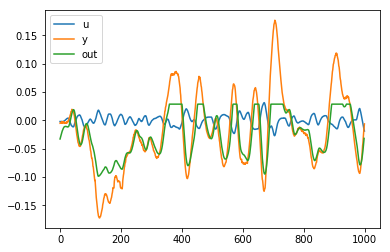

tensor([[-0.0049, -0.0020, -0.0020],
        [-0.0046, -0.0020, -0.0020],
        [-0.0038, -0.0020, -0.0020]])
tensor([[-0.1208],
        [-0.1221],
        [-0.1229]])


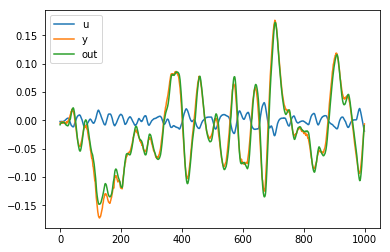

tensor([[-0.0049, -0.0020, -0.0020],
        [-0.0046, -0.0020, -0.0020],
        [-0.0038, -0.0020, -0.0020]])
tensor([[0.1071],
        [0.1071],
        [0.1071]])


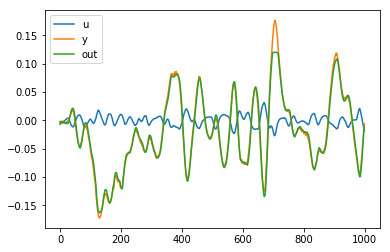

In [7]:
loss_list, model_list = steady_test(10, 1, 1, verbose=False)

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.2710],
        [-0.2728],
        [-0.2741]])


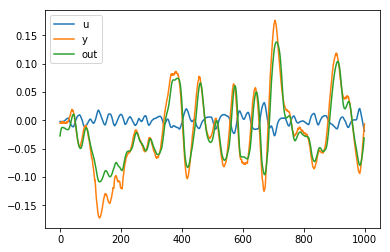

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.1310],
        [-0.1305],
        [-0.1304]])


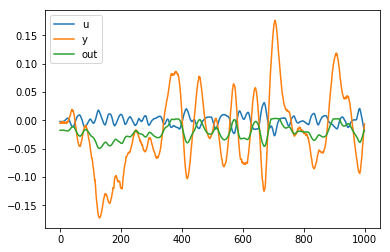

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.0636],
        [-0.0640],
        [-0.0644]])


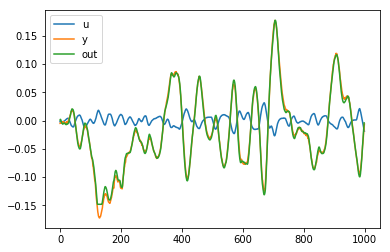

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.2183],
        [0.2161],
        [0.2112]])


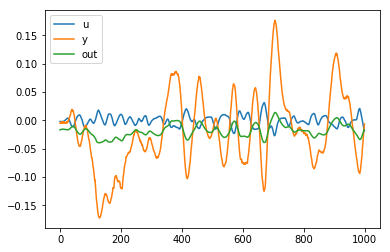

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.0459],
        [-0.0473],
        [-0.0484]])


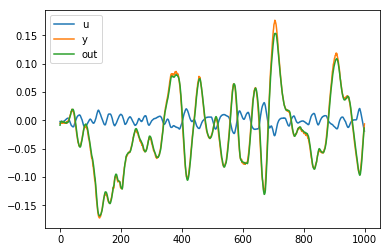

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.2132],
        [0.2118],
        [0.2111]])


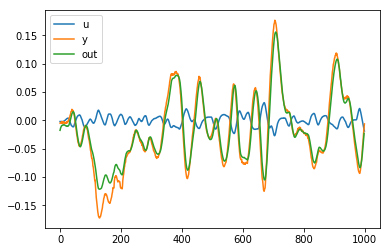

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.5039],
        [-0.5008],
        [-0.5002]])


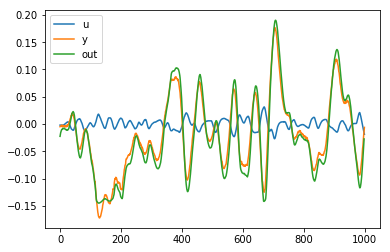

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.1664],
        [-0.1647],
        [-0.1659]])


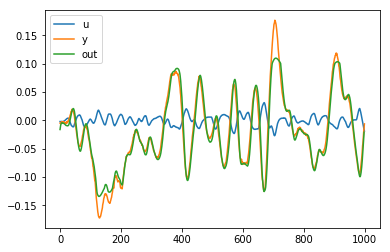

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.3414],
        [0.3414],
        [0.3414]])


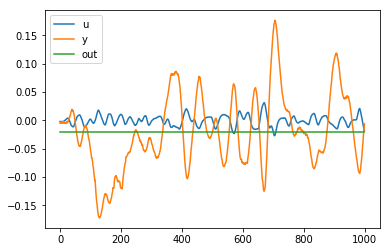

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.3824],
        [0.3944],
        [0.4024]])


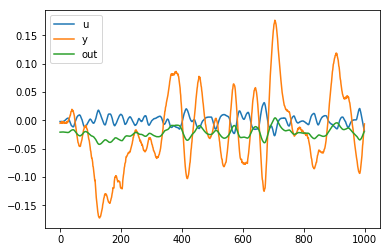

In [8]:
loss_list, model_list = steady_test(10, 1, 0, verbose=False)

tensor([[-0.0020, -0.0020],
        [-0.0020, -0.0020],
        [-0.0020, -0.0020]])
tensor([[-0.4445],
        [-0.4394],
        [-0.4368]])


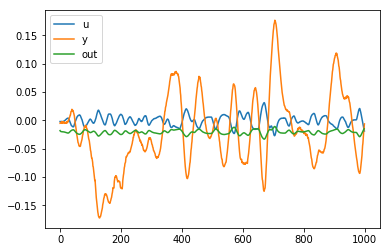

tensor([[-0.0020, -0.0020],
        [-0.0020, -0.0020],
        [-0.0020, -0.0020]])
tensor([[0.1061],
        [0.1098],
        [0.1117]])


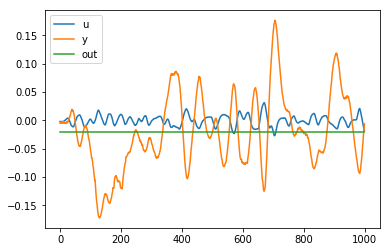

tensor([[-0.0020, -0.0020],
        [-0.0020, -0.0020],
        [-0.0020, -0.0020]])
tensor([[-0.5595],
        [-0.5576],
        [-0.5554]])


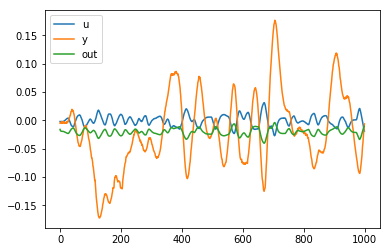

tensor([[-0.0020, -0.0020],
        [-0.0020, -0.0020],
        [-0.0020, -0.0020]])
tensor([[-0.2876],
        [-0.2862],
        [-0.2859]])


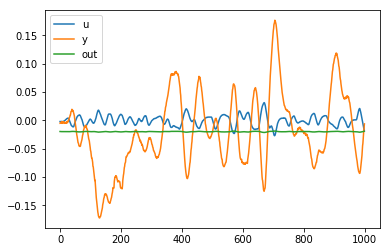

tensor([[-0.0020, -0.0020],
        [-0.0020, -0.0020],
        [-0.0020, -0.0020]])
tensor([[-0.2815],
        [-0.2821],
        [-0.2755]])


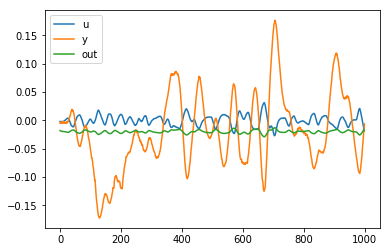

tensor([[-0.0020, -0.0020],
        [-0.0020, -0.0020],
        [-0.0020, -0.0020]])
tensor([[-0.2334],
        [-0.2293],
        [-0.2266]])


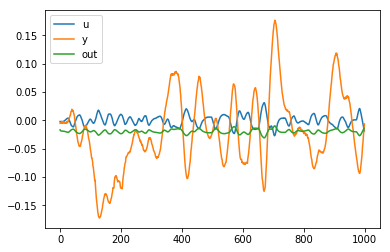

tensor([[-0.0020, -0.0020],
        [-0.0020, -0.0020],
        [-0.0020, -0.0020]])
tensor([[-0.2450],
        [-0.2444],
        [-0.2447]])


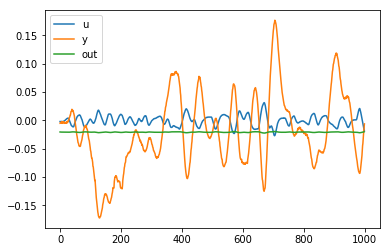

tensor([[-0.0020, -0.0020],
        [-0.0020, -0.0020],
        [-0.0020, -0.0020]])
tensor([[0.3375],
        [0.3329],
        [0.3302]])


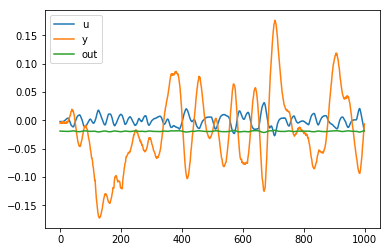

tensor([[-0.0020, -0.0020],
        [-0.0020, -0.0020],
        [-0.0020, -0.0020]])
tensor([[0.2059],
        [0.2042],
        [0.2048]])


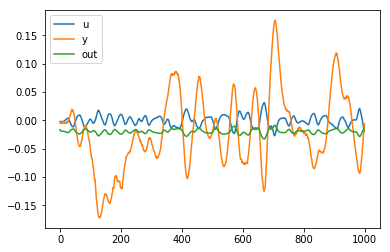

tensor([[-0.0020, -0.0020],
        [-0.0020, -0.0020],
        [-0.0020, -0.0020]])
tensor([[-0.1259],
        [-0.1285],
        [-0.1297]])


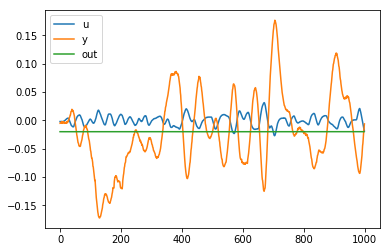

In [10]:
loss_list, model_list = steady_test(10, 0, 1, verbose=False)

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.5007],
        [0.4989],
        [0.4995]])


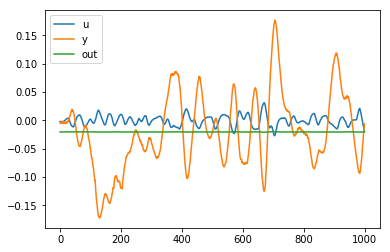

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.4001],
        [0.3812],
        [0.3763]])


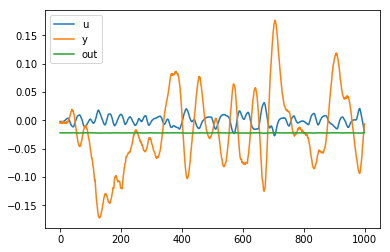

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[-0.3923],
        [-0.3946],
        [-0.3957]])


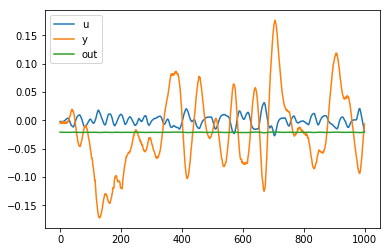

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.1210],
        [0.1164],
        [0.1135]])


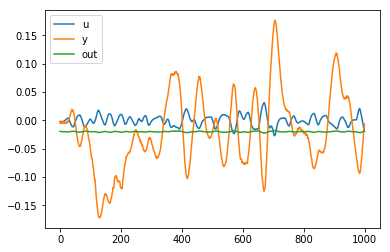

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.3121],
        [0.3082],
        [0.3059]])


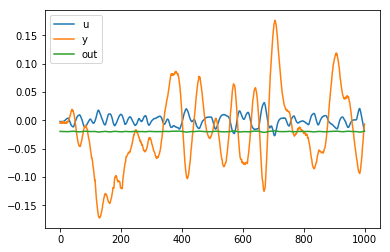

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.2782],
        [0.2794],
        [0.2792]])


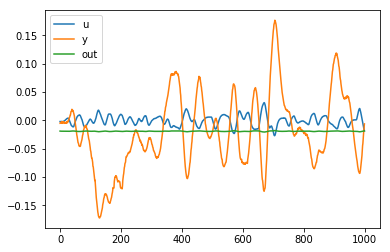

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.3998],
        [0.4017],
        [0.4027]])


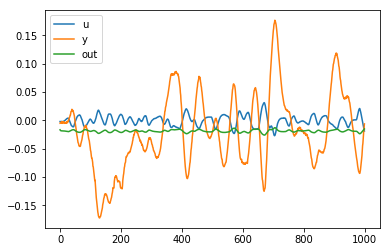

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.1726],
        [0.1686],
        [0.1667]])


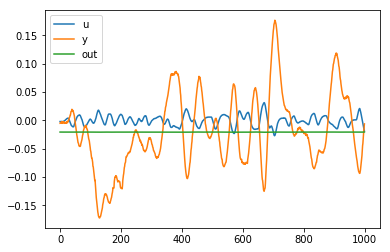

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.1292],
        [0.1311],
        [0.1319]])


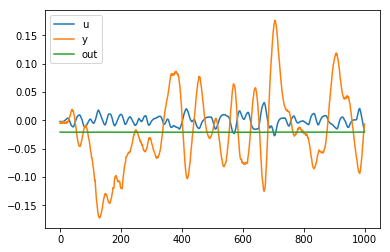

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[-0.0039],
        [-0.0002],
        [ 0.0011]])


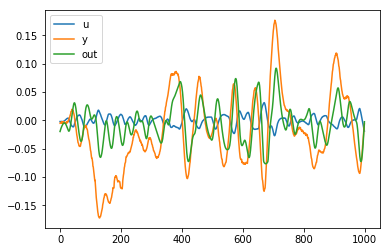

In [9]:
loss_list, model_list = steady_test(10, 0, 0, verbose=False)

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.2368],
        [0.2381],
        [0.2388]])


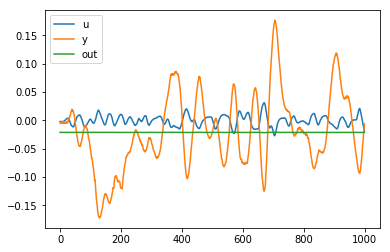

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.4687],
        [0.4762],
        [0.4798]])


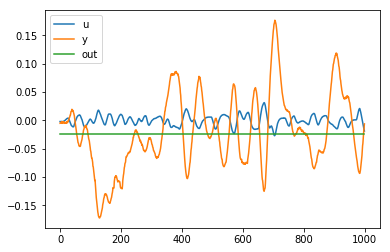

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.1333],
        [0.1383],
        [0.1406]])


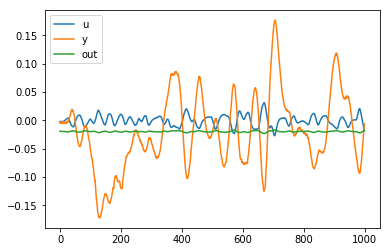

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[-0.5127],
        [-0.5106],
        [-0.5098]])


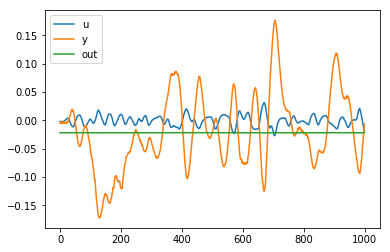

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[-0.1425],
        [-0.1441],
        [-0.1442]])


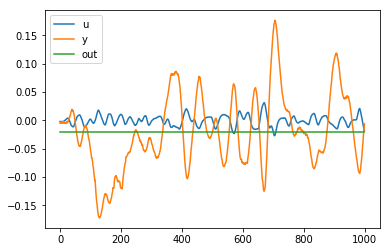

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[-0.0440],
        [-0.0531],
        [-0.0568]])


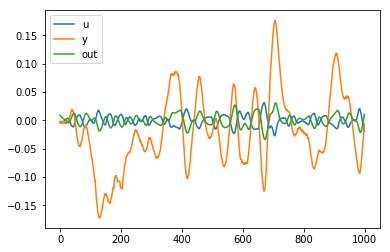

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[-0.2884],
        [-0.2860],
        [-0.2844]])


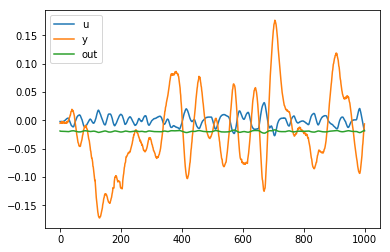

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[-0.1076],
        [-0.1052],
        [-0.1037]])


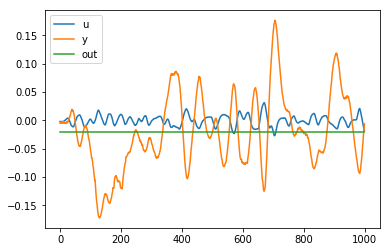

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.0817],
        [0.0737],
        [0.0709]])


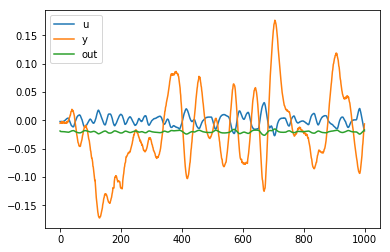

tensor([[-0.0020],
        [-0.0020],
        [-0.0020]])
tensor([[0.1373],
        [0.1500],
        [0.1572]])


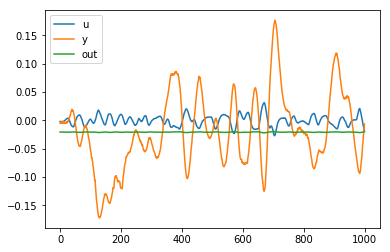

In [11]:
loss_list, model_list = steady_test(10, 0, 0, verbose=False,)

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.0102],
        [-0.0179],
        [-0.0187]])


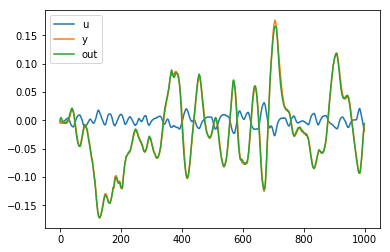

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.3756],
        [-0.3883],
        [-0.3967]])


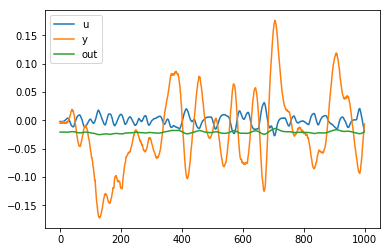

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.3160],
        [0.3160],
        [0.3160]])


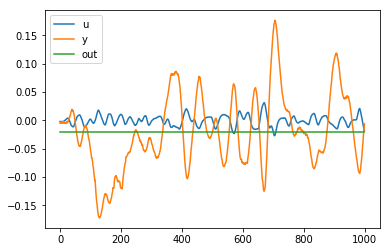

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.1177],
        [-0.1177],
        [-0.1177]])


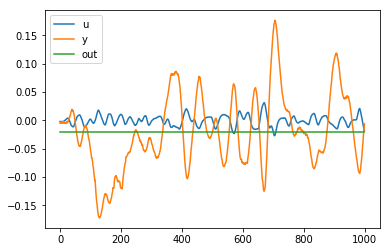

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.2942],
        [0.2943],
        [0.2938]])


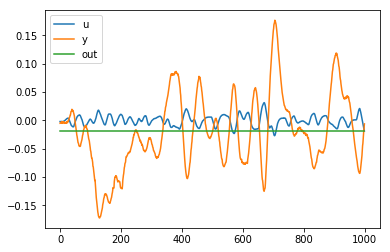

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.0671],
        [-0.0667],
        [-0.0666]])


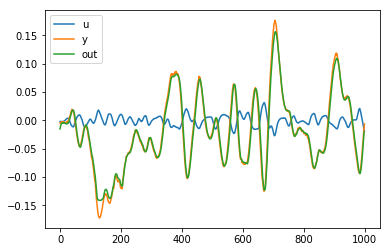

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.0657],
        [0.0657],
        [0.0643]])


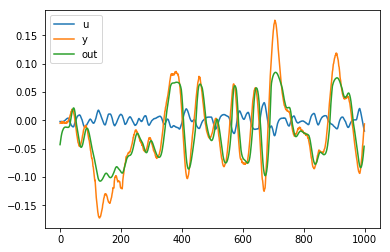

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.6584],
        [0.6584],
        [0.6584]])


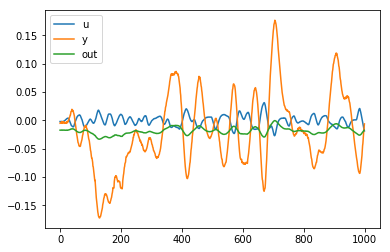

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.3167],
        [0.3167],
        [0.3167]])


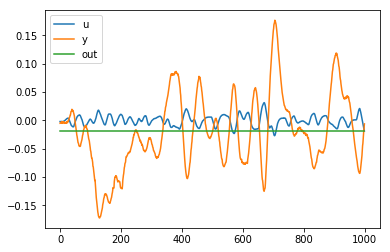

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.1140],
        [0.0843],
        [0.0696]])


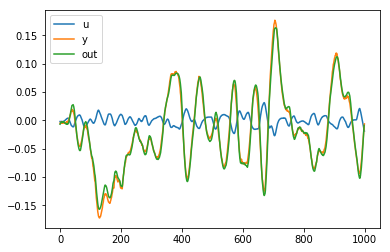

([1.2124389286327641e-05,
  0.004134833347052336,
  0.004394708201289177,
  0.004394854418933392,
  0.004398123361170292,
  0.00013296341057866812,
  0.000768842117395252,
  0.0036137609276920557,
  0.004397239536046982,
  0.00010403022315585986],
 [LSTMSystem(
    (lstm): LSTM(2, 3)
    (fc1): Linear(in_features=3, out_features=3, bias=True)
    (fc2): Linear(in_features=3, out_features=1, bias=True)
  ), LSTMSystem(
    (lstm): LSTM(2, 3)
    (fc1): Linear(in_features=3, out_features=3, bias=True)
    (fc2): Linear(in_features=3, out_features=1, bias=True)
  ), LSTMSystem(
    (lstm): LSTM(2, 3)
    (fc1): Linear(in_features=3, out_features=3, bias=True)
    (fc2): Linear(in_features=3, out_features=1, bias=True)
  ), LSTMSystem(
    (lstm): LSTM(2, 3)
    (fc1): Linear(in_features=3, out_features=3, bias=True)
    (fc2): Linear(in_features=3, out_features=1, bias=True)
  ), LSTMSystem(
    (lstm): LSTM(2, 3)
    (fc1): Linear(in_features=3, out_features=3, bias=True)
    (fc2): Line

In [6]:
loss_list, model_list = steady_test(10, 1, 0, hidden_dim = 3, fc_hidden_dim = 3, verbose = False)

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.5703],
        [0.5703],
        [0.5703]])


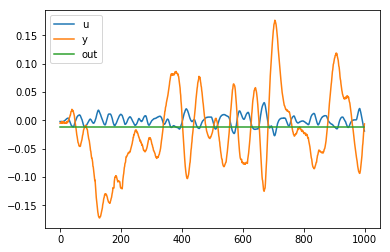

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[1.4531],
        [1.4531],
        [1.4531]])


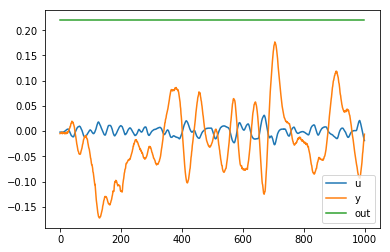

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.5203],
        [0.5203],
        [0.5203]])


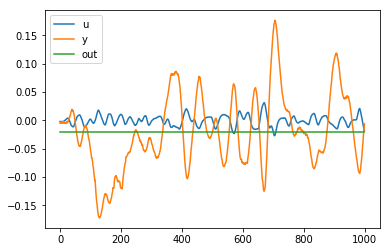

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.5858],
        [0.5858],
        [0.5858]])


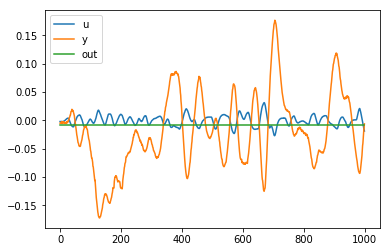

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.7638],
        [0.7638],
        [0.7638]])


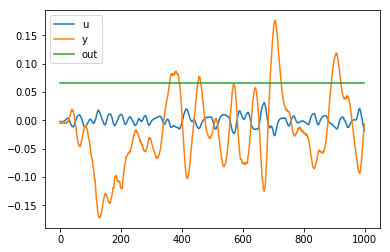

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.4015],
        [-0.4015],
        [-0.4015]])


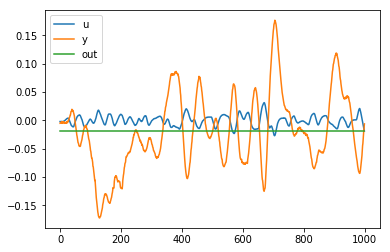

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.2167],
        [0.2165],
        [0.2164]])


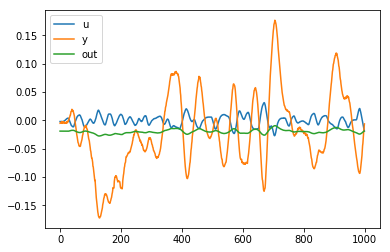

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.5184],
        [-0.5184],
        [-0.5184]])


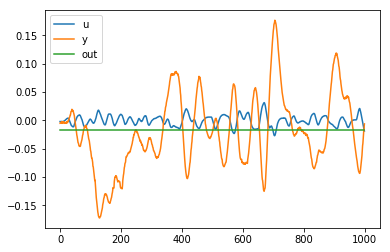

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.9035],
        [-0.9035],
        [-0.9035]])


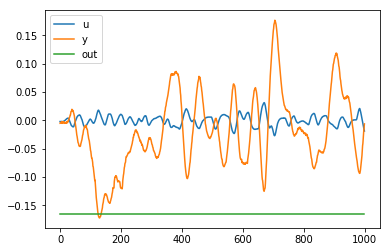

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.0142],
        [-0.1030],
        [-0.1656]])


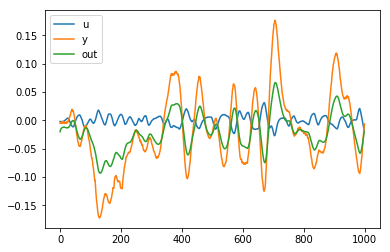

In [7]:
loss_list, model_list = steady_test(10, 1, 0, hidden_dim = 1, fc_hidden_dim = 1, verbose = False)

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.3480],
        [0.3480],
        [0.3480]])


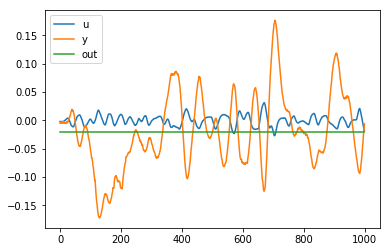

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.5191],
        [0.5159],
        [0.5152]])


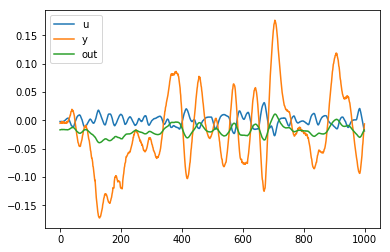

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.3172],
        [-0.3142],
        [-0.3138]])


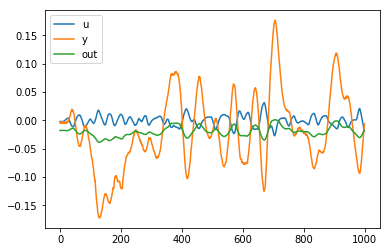

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.4242],
        [-0.4242],
        [-0.4242]])


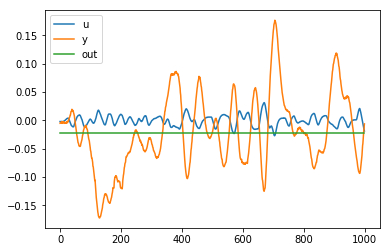

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.2931],
        [0.2987],
        [0.3005]])


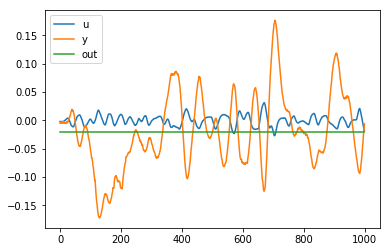

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.1824],
        [-0.1833],
        [-0.1837]])


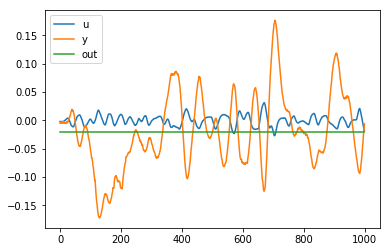

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.2388],
        [-0.2504],
        [-0.2568]])


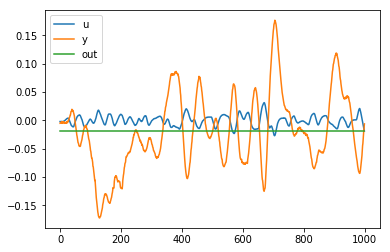

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.2006],
        [-0.2085],
        [-0.2120]])


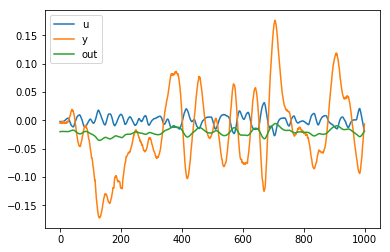

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[-0.1795],
        [-0.1796],
        [-0.1796]])


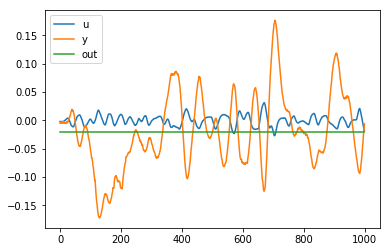

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[0.3277],
        [0.3277],
        [0.3277]])


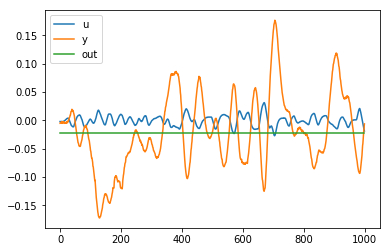

In [8]:
loss_list, model_list = steady_test(10, 1, 0, hidden_dim = 2, fc_hidden_dim = 2, verbose = False)

In [10]:
_y = y
_u = u
y = y[:-50]
u = u[:-50]
#懒得改代码了，直接修改全局变量吧，有这时间我不如看看实变函数。

tensor([[-0.0049, -0.0020],
        [-0.0046, -0.0020],
        [-0.0038, -0.0020]])
tensor([[ 0.0059],
        [ 0.0014],
        [-0.0001]])


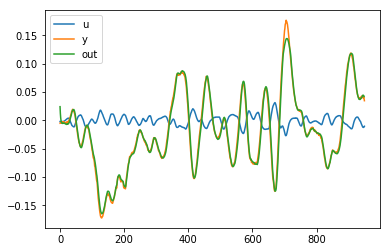

In [12]:
loss, model = test_paramter(1, 0, hidden_dim = 3, fc_hidden_dim = 3, verbose = False)

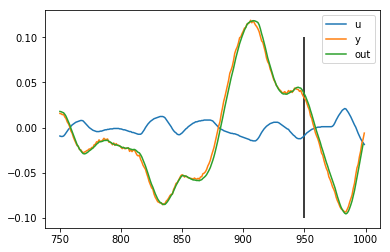

In [83]:
#Y,U = design(_y.reshape(-1), _u.reshape(-1), 1, 0)
Y,U = design(_y.reshape(-1), _u.reshape(-1), 1, 0)

inputs = torch.tensor(U, dtype=torch.float)
targets = torch.tensor(Y.reshape((Y.shape[0],1)), dtype=torch.float)

with torch.no_grad():
    #inputs = torch.tensor([[1.],[2.],[3.],[4.]])
    #model.hidden = model.init_hidden()
    output = model(inputs)
    #loss = loss_function(output, targets)
    #print(output)

idx = np.arange(750,len(_u))
plt.plot(idx,_u[idx],label='u')
plt.plot(idx,_y[idx],label='y')
plt.plot(np.arange(750,len(output)),output.numpy()[750:],label='out')
#plt.plot(np.arange(950,950+50),out_list,label='dyn out')
plt.vlines([950],-0.1,0.1)
plt.legend()
plt.show()


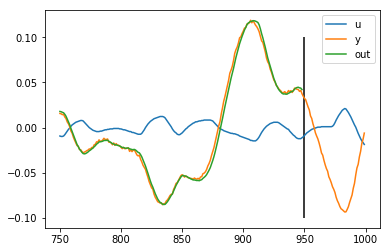

In [103]:
#Y,U = design(_y.reshape(-1), _u.reshape(-1), 1, 0)
Y,U = design(y.reshape(-1), u.reshape(-1), 1, 0)

inputs = torch.tensor(U, dtype=torch.float)
targets = torch.tensor(Y.reshape((Y.shape[0],1)), dtype=torch.float)

with torch.no_grad():
    #inputs = torch.tensor([[1.],[2.],[3.],[4.]])
    #model.hidden = model.init_hidden()
    output = model(inputs)
    #loss = loss_function(output, targets)
    #print(output)

idx = np.arange(750,len(_u))
plt.plot(idx,_u[idx],label='u')
plt.plot(idx,_y[idx],label='y')
plt.plot(np.arange(750,len(output)),output.numpy()[750:],label='out')
#plt.plot(np.arange(950,950+50),out_list,label='dyn out')
plt.vlines([950],-0.1,0.1)
plt.legend()
plt.show()


In [104]:
_h = model.hidden

In [105]:
model.hidden = _h

with torch.no_grad():

    out = output[-1]

    out_list = []
    for __u in _u[-50:]:
        inputs = torch.tensor([[out, __u]], dtype=torch.float)
        lstm_out, model.hidden = model.lstm(
            inputs.view(len(inputs), 1, -1), model.hidden)
        out = F.relu(lstm_out)
        out = model.fc1(out.view(len(inputs), -1))
        out = F.relu(out)
        out = model.fc2(out)
        out_list.append(out.item())

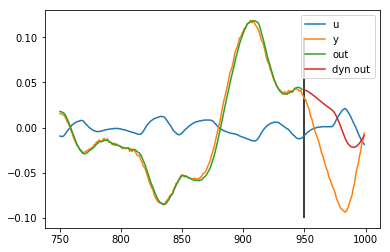

In [106]:
idx = np.arange(750,len(_u))
plt.plot(idx,_u[idx],label='u')
plt.plot(idx,_y[idx],label='y')
plt.plot(np.arange(750,len(output)),output.numpy()[750:],label='out')
plt.plot(np.arange(950,950+50),out_list,label='dyn out')
plt.vlines([950],-0.1,0.1)
plt.legend()
plt.show()


In [107]:
model.hidden = _h

new_u = np.random.randn(50)*np.std(_u)
with torch.no_grad():

    out = output[-1]

    out_list = []
    for __u in new_u:
        inputs = torch.tensor([[out, __u]], dtype=torch.float)
        lstm_out, model.hidden = model.lstm(
            inputs.view(len(inputs), 1, -1), model.hidden)
        out = F.relu(lstm_out)
        out = model.fc1(out.view(len(inputs), -1))
        out = F.relu(out)
        out = model.fc2(out)
        out_list.append(out.item())

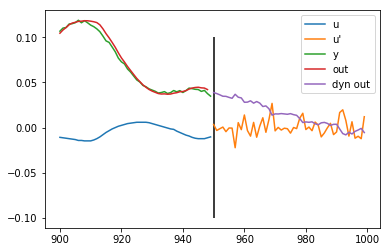

In [110]:
start = 900
idx = np.arange(start,len(u))
plt.plot(idx,u[idx],label='u')
plt.plot(np.arange(950,950+50),new_u,label="u'")
plt.plot(idx,y[idx],label='y')
plt.plot(np.arange(start,len(output)),output.numpy()[start:],label='out')
plt.plot(np.arange(950,950+50),out_list,label='dyn out')
plt.vlines([950],-0.1,0.1)
plt.legend()
plt.show()


In [112]:
model.hidden = _h

new_u = np.ones(50)*np.std(_u)
with torch.no_grad():

    out = output[-1]

    out_list = []
    for __u in new_u:
        inputs = torch.tensor([[out, __u]], dtype=torch.float)
        lstm_out, model.hidden = model.lstm(
            inputs.view(len(inputs), 1, -1), model.hidden)
        out = F.relu(lstm_out)
        out = model.fc1(out.view(len(inputs), -1))
        out = F.relu(out)
        out = model.fc2(out)
        out_list.append(out.item())

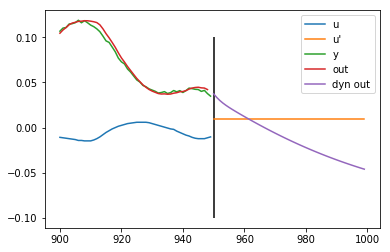

In [113]:
start = 900
idx = np.arange(start,len(u))
plt.plot(idx,u[idx],label='u')
plt.plot(np.arange(950,950+50),new_u,label="u'")
plt.plot(idx,y[idx],label='y')
plt.plot(np.arange(start,len(output)),output.numpy()[start:],label='out')
plt.plot(np.arange(950,950+50),out_list,label='dyn out')
plt.vlines([950],-0.1,0.1)
plt.legend()
plt.show()


In [118]:
model.hidden = _h

new_u = np.linspace(0,1,50)*np.std(_u)
with torch.no_grad():

    out = output[-1]

    out_list = []
    for __u in new_u:
        inputs = torch.tensor([[out, __u]], dtype=torch.float)
        lstm_out, model.hidden = model.lstm(
            inputs.view(len(inputs), 1, -1), model.hidden)
        out = F.relu(lstm_out)
        out = model.fc1(out.view(len(inputs), -1))
        out = F.relu(out)
        out = model.fc2(out)
        out_list.append(out.item())

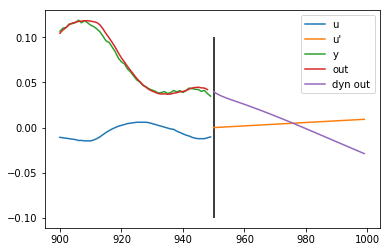

In [119]:
start = 900
idx = np.arange(start,len(u))
plt.plot(idx,u[idx],label='u')
plt.plot(np.arange(950,950+50),new_u,label="u'")
plt.plot(idx,y[idx],label='y')
plt.plot(np.arange(start,len(output)),output.numpy()[start:],label='out')
plt.plot(np.arange(950,950+50),out_list,label='dyn out')
plt.vlines([950],-0.1,0.1)
plt.legend()
plt.show()


In [120]:
model.hidden = _h

new_u = np.sin(np.linspace(0,50,50))*np.std(_u)
with torch.no_grad():

    out = output[-1]

    out_list = []
    for __u in new_u:
        inputs = torch.tensor([[out, __u]], dtype=torch.float)
        lstm_out, model.hidden = model.lstm(
            inputs.view(len(inputs), 1, -1), model.hidden)
        out = F.relu(lstm_out)
        out = model.fc1(out.view(len(inputs), -1))
        out = F.relu(out)
        out = model.fc2(out)
        out_list.append(out.item())

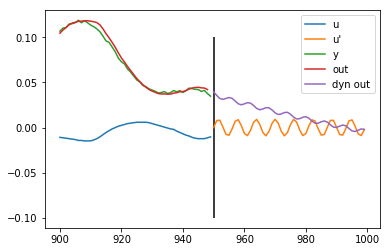

In [121]:
start = 900
idx = np.arange(start,len(u))
plt.plot(idx,u[idx],label='u')
plt.plot(np.arange(950,950+50),new_u,label="u'")
plt.plot(idx,y[idx],label='y')
plt.plot(np.arange(start,len(output)),output.numpy()[start:],label='out')
plt.plot(np.arange(950,950+50),out_list,label='dyn out')
plt.vlines([950],-0.1,0.1)
plt.legend()
plt.show()


In [124]:
torch.save(model,'ballbeam_lstm.pt')

D:\anaconda\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LSTMSystem. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
